# 3MD3220: Reinforcement Learning - Text Flappy Bird Project

**Author**: Clément Leprêtre  
**Date**: March 2025  
**Description**: This notebook implements and compares Monte Carlo and Sarsa(λ) agents for the Text Flappy Bird (TFB) environment (`TextFlappyBird-v0`). It includes training, evaluation, and visualization of state-value functions, reward convergence, and parameter sweeps.

## 1. Setup and Imports

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools

# Install the Text Flappy Bird environment (adjust as per GitLab instructions)
# !pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git
import text_flappy_bird_gym
# Set random seed for reproducibility
np.random.seed(42)

## 2. Environment Initialization

In [250]:
# Initialize the TextFlappyBird-v0 environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap=4)

# Environment parameters
n_actions = env.action_space.n  # 0: do nothing, 1: flap
obs_space = env.observation_space  # Check the observation space

# Test the environment
import random
import os
random.seed(42)
np.random.seed(42)
os.environ["PYTHONHASHSEED"] = "42"
state, _ = env.reset(seed=42)
print(f'Initial State: {state}')
print(f'Action space: {n_actions}, Observation space: {obs_space}')

Initial State: (13, 3)
Action space: 2, Observation space: Tuple(Discrete(14), Discrete(22, start=-11))


## 3. Monte Carlo Agent

In [160]:
class MonteCarloAgent:
    def __init__(self, n_actions, gamma=0.95, epsilon_start=0.9, epsilon_end=0.01, epsilon_decay=0.999):
        self.n_actions = n_actions
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.epsilon = epsilon_start
        self.gamma = gamma
        self.Q = defaultdict(lambda: np.zeros(n_actions))
        self.returns = defaultdict(list)
        
    def choose_action(self, state):
        # Convertir l'état en tuple pour qu'il soit hashable
        state = tuple(state) if isinstance(state, np.ndarray) else state
        
        if np.random.random() < self.epsilon:
            return np.random.choice(self.n_actions)
        return np.argmax(self.Q[state])
    
    def update(self, episode):
        states, actions, rewards = zip(*episode)
        G = 0
        for t in range(len(states) - 1, -1, -1):
            G = rewards[t] + self.gamma * G
            
            # Convertir l'état en tuple pour qu'il soit hashable
            state = tuple(states[t]) if isinstance(states[t], np.ndarray) else states[t]
            action = actions[t]
            
            # Vérifier pour first-visit
            if (state, action) not in [(tuple(states[i]) if isinstance(states[i], np.ndarray) else states[i], actions[i]) for i in range(t)]:
                self.returns[(state, action)].append(G)
                self.Q[state][action] = np.mean(self.returns[(state, action)])

def train_mc_agent(env, agent, episodes=2001, max_steps=10000, early_stop_reward=None, patience=100, reward_window=100):
    rewards = []
    pipes_passed_list = []
    best_avg_reward = float('-inf')
    patience_counter = 0
    
    for ep in range(episodes):
        # Handle env.reset() return
        state, info = env.reset(seed=42)
            
        # Convertir état en tuple si c'est un array
        state = tuple(state) if isinstance(state, np.ndarray) else state
            
        episode = []
        total_reward = 0
        pipes_passed = 0
        
        # Initialiser last_pipe_x correctement
        last_pipe_x = state[0] if isinstance(state, tuple) and len(state) > 0 else 0
        
        done = False
        step_count = 0
        
        while not done and step_count < max_steps:
            step_count += 1
            action = agent.choose_action(state)
            
            # Handle full step return avec gestion des différentes API gym
            step_result = env.step(action)
            next_state, reward, done, truncated, info = step_result
                        
            # Track pipes passed de façon sécurisée
            if isinstance(next_state, tuple) and len(next_state) > 0 and isinstance(state, tuple) and len(state) > 0:
                if next_state[0] > last_pipe_x:
                    pipes_passed += 1
                    # S'assurer que next_state a au moins 2 éléments avant d'accéder à l'index 1
                    last_pipe_x = next_state[1] if len(next_state) > 1 else next_state[0]
                last_pipe_x = next_state[0]
            
            episode.append((state, action, reward))
            state = next_state
            total_reward += reward
            
            # Limite de sécurité pour éviter les boucles infinies
            if step_count >= max_steps:
                print(f"Épisode {ep} interrompu après {max_steps} étapes")
                break
                
        # Mise à jour de l'epsilon
        agent.epsilon = max(agent.epsilon_end, agent.epsilon * agent.epsilon_decay)
        
        # Mettre à jour l'agent avec l'épisode terminé
        agent.update(episode)
        
        rewards.append(total_reward)
        pipes_passed_list.append(pipes_passed)
        
        # Early stopping basé sur la récompense
        if len(rewards) >= reward_window:
            current_avg_reward = np.mean(rewards[-reward_window:])
            avg_pipe = np.mean(pipes_passed_list[-min(reward_window, len(pipes_passed_list)):])
            
            # Affichage périodique des statistiques
            if ep % 500 == 0:
                print(f'Episode {ep}, Avg Reward: {current_avg_reward:.2f}, ' +
                      f'Avg Pipes Passed: {avg_pipe:.2f}, ' +
                      f'Epsilon: {agent.epsilon:.2f}')
            
            # Si une cible de récompense spécifique est fournie
            if early_stop_reward is not None and current_avg_reward >= early_stop_reward:
                print(f"Early stopping atteint à l'épisode {ep}. Récompense moyenne: {current_avg_reward:.2f} >= {early_stop_reward}")
                break
            
            # Early stopping basé sur la patience (arrêt si pas d'amélioration)
            if current_avg_reward > best_avg_reward:
                best_avg_reward = current_avg_reward
                best_avg_pipe = avg_pipe
                patience_counter = 0
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                print(f"Early stopping par patience à l'épisode {ep}. Pas d'amélioration depuis {patience} épisodes.")
                break
    
    print(f"Entraînement terminé après {ep+1} épisodes. Meilleure récompense moyenne: {best_avg_reward:.2f}, " 
          + f"Meilleure moyenne de tuyaux passés: {best_avg_pipe:.2f}")
    return rewards, pipes_passed_list

In [253]:
random.seed(42)
np.random.seed(42)

mc_agent = MonteCarloAgent(n_actions)
mc_rewards, mc_pipes_passed = train_mc_agent(env, mc_agent, episodes=2001, patience=300)

Episode 500, Avg Reward: 23.67, Avg Pipes Passed: 1.26, Epsilon: 0.55
Episode 1000, Avg Reward: 36.72, Avg Pipes Passed: 2.54, Epsilon: 0.33
Episode 1500, Avg Reward: 63.29, Avg Pipes Passed: 5.11, Epsilon: 0.20
Episode 2000, Avg Reward: 110.92, Avg Pipes Passed: 9.87, Epsilon: 0.12
Entraînement terminé après 2001 épisodes. Meilleure récompense moyenne: 110.92, Meilleure moyenne de tuyaux passés: 9.87


## 4. Sarsa(λ) Agent

In [256]:
import numpy as np
from collections import defaultdict

# SarsaLambdaAgent optimisé
class SarsaLambdaAgent:
    def __init__(self, n_actions, alpha=0.1, lambda_=0.9, gamma=0.95, epsilon_start=0.9, epsilon_end=0.01, epsilon_decay=0.999):
        self.n_actions = n_actions
        self.alpha = alpha
        self.lambda_ = lambda_
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.Q = defaultdict(lambda: np.zeros(n_actions))
        self.E = defaultdict(lambda: np.zeros(n_actions))
        self.update_count = 0
        self.cleanup_frequency = 100  # Nettoyage des traces tous les 100 updates
        
    def choose_action(self, state):
        state = self._hashable_state(state)
        if np.random.random() < self.epsilon:
            return np.random.choice(self.n_actions)
        return np.argmax(self.Q[state])
    
    def _hashable_state(self, state):
        """Convertit l'état en une forme hashable pour les dictionnaires"""
        if isinstance(state, np.ndarray):
            return tuple(state.flatten())
        elif isinstance(state, tuple) or isinstance(state, list):
            return tuple(state)
        return state
        
    def update(self, state, action, reward, next_state, next_action, done):
        state = self._hashable_state(state)
        next_state = self._hashable_state(next_state)
        
        q_next = 0 if done else self.Q[next_state][next_action]
        td_error = reward + self.gamma * q_next - self.Q[state][action]
        
        # Incrémente la trace d'éligibilité pour l'état-action courant
        self.E[state][action] += 1
        
        # Mise à jour optimisée: ne traite que les états avec traces non-nulles
        states_with_traces = [s for s in list(self.E.keys()) if np.any(self.E[s] > 1e-5)]
        
        # Mise à jour vectorisée des valeurs Q et des traces d'éligibilité
        for s in states_with_traces:
            self.Q[s] += self.alpha * td_error * self.E[s]
            self.E[s] *= self.gamma * self.lambda_
        
        # Nettoyage périodique des traces faibles
        self.update_count += 1
        if self.update_count % self.cleanup_frequency == 0:
            self._cleanup_traces()
    
    def _cleanup_traces(self):
        """Supprime les traces d'éligibilité trop faibles pour économiser de la mémoire"""
        to_remove = []
        threshold = 1e-5
        
        for s in self.E:
            if np.max(self.E[s]) < threshold:
                to_remove.append(s)
        
        for s in to_remove:
            del self.E[s]


# Boucle d'entraînement optimisée
def train_sarsa_agent(env, agent, episodes=10000, max_steps=1000, early_stop_reward=None, patience=50, reward_window=100, log_frequency=500):
    rewards = []
    pipes_passed_list = []
    best_avg_reward = float('-inf')
    best_avg_pipe = 0
    patience_counter = 0
    
    for ep in range(episodes):
        state, _ = env.reset(seed=42)
        action = agent.choose_action(state)
        total_reward = 0
        done = False
        truncated = False
        pipes_passed = 0
        last_pipe_x = state[0] if isinstance(state, tuple) and len(state) > 0 else 0
        
        # Boucle de l'épisode avec limite de pas
        step_count = 0
        
        while not (done or truncated) and step_count < max_steps:
            step_count += 1
            
            next_state, reward, done, truncated, _ = env.step(action)
            
            # Comptage des pipes passés - vectorisé si possible
            if isinstance(next_state, tuple) and len(next_state) > 0:
                if next_state[0] > last_pipe_x:
                    pipes_passed += 1
                last_pipe_x = next_state[0]
                
            next_action = agent.choose_action(next_state)
            agent.update(state, action, reward, next_state, next_action, done or truncated)
            
            state, action = next_state, next_action
            total_reward += reward
            
        # Enregistrement des statistiques - utilisation de append() est efficace
        rewards.append(total_reward)
        pipes_passed_list.append(pipes_passed)
        
        # Mise à jour du epsilon - opération simple
        agent.epsilon = max(agent.epsilon_end, agent.epsilon * agent.epsilon_decay)
        
        # Vérification de l'early stopping et affichage périodique
        if len(rewards) >= reward_window:
            # Utilisation de slicing efficace pour calculer les moyennes
            current_avg_reward = np.mean(rewards[-reward_window:])
            avg_pipes = np.mean(pipes_passed_list[-reward_window:])
            
            # Affichage réduit pour éviter les ralentissements I/O
            if ep % log_frequency == 0:
                print(f'Episode {ep}, Avg Reward: {current_avg_reward:.2f}, Avg Pipes: {avg_pipes:.2f}, Epsilon: {agent.epsilon:.3f}')
            
            # Early stopping basé sur un seuil de récompense
            if early_stop_reward is not None and current_avg_reward >= early_stop_reward:
                print(f"Early stopping atteint à l'épisode {ep}. Récompense moyenne: {current_avg_reward:.2f} >= {early_stop_reward}")
                break
                
            # Early stopping basé sur la patience
            if current_avg_reward > best_avg_reward:
                best_avg_pipe = avg_pipes
                best_avg_reward = current_avg_reward
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                print(f"Early stopping par patience à l'épisode {ep}. Pas d'amélioration depuis {patience} épisodes.")
                break
        elif ep % log_frequency == 0:  # Affichage réduit
            print(f'Episode {ep}, Reward: {total_reward:.2f}, Pipes: {pipes_passed}, Epsilon: {agent.epsilon:.3f}')
    
    print(f"Entraînement terminé après {ep+1} épisodes. Meilleure récompense moyenne: {best_avg_reward:.2f}. Meilleur nombre de pipes: {best_avg_pipe:.2f}")
    return rewards, pipes_passed_list

In [257]:
sarsa_agent = SarsaLambdaAgent(n_actions, lambda_=0.7, alpha=.1, gamma=0.95)   

In [258]:
sarsa_rewards, sarsa_pipes_passed = train_sarsa_agent(env, sarsa_agent, episodes=2001, max_steps=10000, patience=300)

Episode 0, Reward: 7.00, Pipes: 0, Epsilon: 0.899
Episode 500, Avg Reward: 17.24, Avg Pipes: 0.61, Epsilon: 0.545
Episode 1000, Avg Reward: 28.12, Avg Pipes: 1.71, Epsilon: 0.331
Episode 1500, Avg Reward: 60.63, Avg Pipes: 4.90, Epsilon: 0.200
Episode 2000, Avg Reward: 84.69, Avg Pipes: 7.25, Epsilon: 0.122
Entraînement terminé après 2001 épisodes. Meilleure récompense moyenne: 86.21. Meilleur nombre de pipes: 7.41


## 5. Parameters Sweep

Running MonteCarloAgent with gamma=0.85
Episode 0, Avg Reward: 21.00, Avg Pipes Passed: 1.00, Epsilon: 0.90
Episode 500, Avg Reward: 32.03, Avg Pipes Passed: 2.23, Epsilon: 0.55
Episode 1000, Avg Reward: 59.51, Avg Pipes Passed: 4.93, Epsilon: 0.33
Episode 1500, Avg Reward: 167.12, Avg Pipes Passed: 15.62, Epsilon: 0.20
Episode 2000, Avg Reward: 511.55, Avg Pipes Passed: 50.03, Epsilon: 0.12
Running MonteCarloAgent with gamma=0.9
Episode 0, Avg Reward: 10.00, Avg Pipes Passed: 0.00, Epsilon: 0.90
Episode 500, Avg Reward: 30.31, Avg Pipes Passed: 2.05, Epsilon: 0.55
Episode 1000, Avg Reward: 60.42, Avg Pipes Passed: 5.02, Epsilon: 0.33
Episode 1500, Avg Reward: 163.99, Avg Pipes Passed: 15.32, Epsilon: 0.20
Episode 2000, Avg Reward: 460.66, Avg Pipes Passed: 44.96, Epsilon: 0.12
Running MonteCarloAgent with gamma=0.95
Episode 0, Avg Reward: 23.00, Avg Pipes Passed: 1.00, Epsilon: 0.90
Episode 500, Avg Reward: 30.03, Avg Pipes Passed: 2.05, Epsilon: 0.55
Episode 1000, Avg Reward: 59.86, 

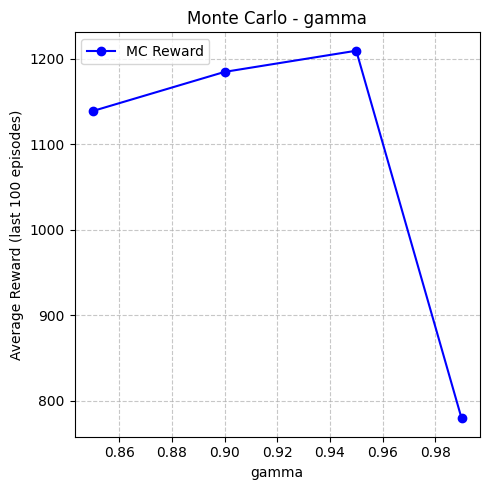

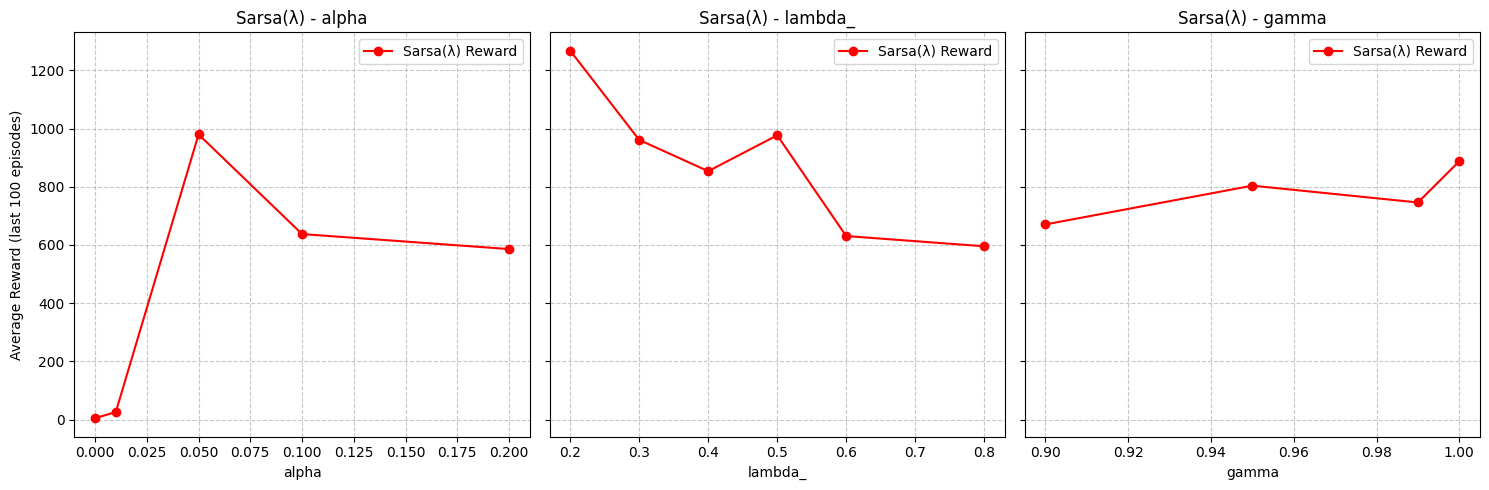

In [ ]:
def run_sweep(agent_class, env, param_name, param_values, fixed_params, episodes=2001):
    rewards_means = []
    for val in param_values:
        params = fixed_params.copy()
        params[param_name] = val
        agent = agent_class(**params)
        print(f'Running {agent_class.__name__} with {param_name}={val}')
        if agent_class == MonteCarloAgent:
            rewards, _ = train_mc_agent(env, agent, episodes=episodes)
        else:
            rewards, _ = train_sarsa_agent(env, agent, episodes=episodes)
        rewards_means.append(np.mean(rewards[-100:]))
    return rewards_means

def plot_sweep(mc_results, sarsa_results, mc_params, sarsa_params):
    num_mc = len(mc_params)
    num_sarsa = len(sarsa_params)
    
    # Monte Carlo plots
    fig, axs = plt.subplots(1, num_mc, figsize=(5 * num_mc, 5), sharey=True)
    axs = np.atleast_1d(axs)  # Ensure axs is always an array
    
    for i, (param_name, param_values) in enumerate(mc_params.items()):
        rewards_means = mc_results[i]
        axs[i].plot(param_values, rewards_means, 'o-', color='b', label='MC Reward')
        axs[i].set_xlabel(param_name)
        axs[i].set_title(f'Monte Carlo - {param_name}')
        axs[i].grid(True, linestyle='--', alpha=0.7)
        axs[i].legend()
    
    if num_mc > 0:
        axs[0].set_ylabel('Average Reward (last 100 episodes)')
    plt.tight_layout()
    plt.savefig('figures/sweep_mc.png', bbox_inches='tight')
    plt.show()
    
    # Sarsa(λ) plots
    fig, axs = plt.subplots(1, num_sarsa, figsize=(5 * num_sarsa, 5), sharey=True)
    axs = np.atleast_1d(axs)  # Ensure axs is always an array
    
    for i, (param_name, param_values) in enumerate(sarsa_params.items()):
        rewards_means = sarsa_results[i]
        axs[i].plot(param_values, rewards_means, 'o-', color='r', label='Sarsa(λ) Reward')
        axs[i].set_xlabel(param_name)
        axs[i].set_title(f'Sarsa(λ) - {param_name}')
        axs[i].grid(True, linestyle='--', alpha=0.7)
        axs[i].legend()
    
    if num_sarsa > 0:
        axs[0].set_ylabel('Average Reward (last 100 episodes)')
    plt.tight_layout()
    plt.savefig('figures/sweep_sarsa.png', bbox_inches='tight')
    plt.show()

# Monte Carlo Sweeps
mc_fixed_params = {'n_actions': n_actions, 'gamma': 0.95}
mc_params = {'gamma': [0.85, 0.9, 0.95, 0.99]}

# Sarsa(λ) Sweeps
sarsa_fixed_params = {'n_actions': n_actions, 'alpha': 0.1, 'lambda_': 0.6, 'gamma': 0.9}
sarsa_params = {'alpha': [0, 0.01, 0.05, 0.1, 0.2], 'lambda_': [0.2, 0.3, 0.4, 0.5, 0.6, 0.8], 'gamma': [0.9, 0.95, 0.99, 1.0]}

# Run sweeps
mc_results = [run_sweep(MonteCarloAgent, env, param_name, param_values, mc_fixed_params) for param_name, param_values in mc_params.items()]
sarsa_results = [run_sweep(SarsaLambdaAgent, env, param_name, param_values, sarsa_fixed_params) for param_name, param_values in sarsa_params.items()]

# Plot all sweeps
plot_sweep(mc_results, sarsa_results, mc_params, sarsa_params)


## 6. Training the best agent

In [283]:
random.seed(42)
np.random.seed(42)

mc_agent = MonteCarloAgent(n_actions, gamma=0.95)
mc_rewards, mc_pipes_passed = train_mc_agent(env, mc_agent, episodes=10000, patience=10000, max_steps=8000)

Episode 500, Avg Reward: 23.67, Avg Pipes Passed: 1.26, Epsilon: 0.55
Episode 1000, Avg Reward: 36.72, Avg Pipes Passed: 2.54, Epsilon: 0.33
Episode 1500, Avg Reward: 63.29, Avg Pipes Passed: 5.11, Epsilon: 0.20
Episode 2000, Avg Reward: 110.92, Avg Pipes Passed: 9.87, Epsilon: 0.12
Episode 2500, Avg Reward: 156.87, Avg Pipes Passed: 14.45, Epsilon: 0.07
Episode 3000, Avg Reward: 313.83, Avg Pipes Passed: 30.13, Epsilon: 0.04
Episode 3500, Avg Reward: 510.94, Avg Pipes Passed: 49.85, Epsilon: 0.03
Episode 4000, Avg Reward: 777.61, Avg Pipes Passed: 76.50, Epsilon: 0.02
Épisode 4425 interrompu après 8000 étapes
Episode 4500, Avg Reward: 1258.22, Avg Pipes Passed: 124.58, Epsilon: 0.01
Episode 5000, Avg Reward: 1421.99, Avg Pipes Passed: 140.96, Epsilon: 0.01
Épisode 5050 interrompu après 8000 étapes
Épisode 5140 interrompu après 8000 étapes
Épisode 5198 interrompu après 8000 étapes
Épisode 5394 interrompu après 8000 étapes
Épisode 5442 interrompu après 8000 étapes
Episode 5500, Avg Rewa

In [284]:
random.seed(42)
np.random.seed(42)
sarsa_agent = SarsaLambdaAgent(n_actions, lambda_=.72, alpha=.23, gamma=.99)   
sarsa_rewards, sarsa_pipes_passed = train_sarsa_agent(env, sarsa_agent, episodes=10000, max_steps=8000, patience=10000)

Episode 0, Reward: 13.00, Pipes: 0, Epsilon: 0.899
Episode 500, Avg Reward: 19.08, Avg Pipes: 0.78, Epsilon: 0.545
Episode 1000, Avg Reward: 34.68, Avg Pipes: 2.35, Epsilon: 0.331
Episode 1500, Avg Reward: 46.89, Avg Pipes: 3.55, Epsilon: 0.200
Episode 2000, Avg Reward: 82.92, Avg Pipes: 7.12, Epsilon: 0.122
Episode 2500, Avg Reward: 107.65, Avg Pipes: 9.57, Epsilon: 0.074
Episode 3000, Avg Reward: 205.95, Avg Pipes: 19.38, Epsilon: 0.045
Episode 3500, Avg Reward: 330.85, Avg Pipes: 31.89, Epsilon: 0.027
Episode 4000, Avg Reward: 490.00, Avg Pipes: 47.78, Epsilon: 0.016
Episode 4500, Avg Reward: 640.94, Avg Pipes: 62.91, Epsilon: 0.010
Episode 5000, Avg Reward: 780.51, Avg Pipes: 76.87, Epsilon: 0.010
Episode 5500, Avg Reward: 872.92, Avg Pipes: 86.11, Epsilon: 0.010
Episode 6000, Avg Reward: 796.35, Avg Pipes: 78.47, Epsilon: 0.010
Episode 6500, Avg Reward: 808.01, Avg Pipes: 79.64, Epsilon: 0.010
Episode 7000, Avg Reward: 627.13, Avg Pipes: 61.54, Epsilon: 0.010
Episode 7500, Avg Rew

## 7. Visualization

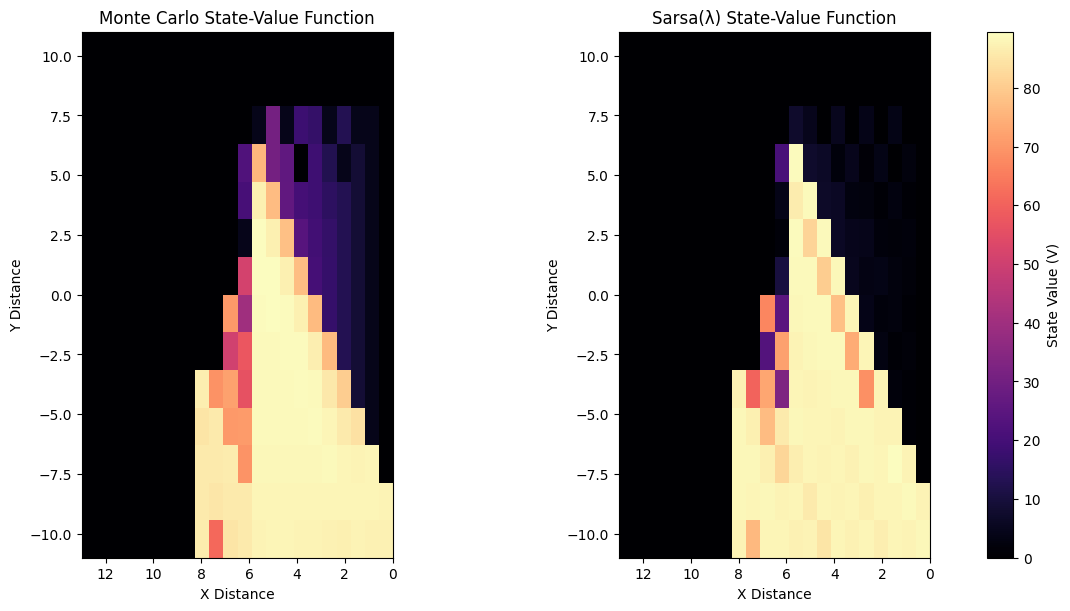

In [297]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_state_value(mc_agent, sarsa_agent):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
    titles = ['Monte Carlo State-Value Function', "Sarsa(λ) State-Value Function"]
    agents = [mc_agent, sarsa_agent]

    # Définition des limites
    x_min, x_max = 0, 13  # X allant de 0 à 13 (14 valeurs)
    y_min, y_max = -11, 11  # Y centré entre -11 et 11 (22 valeurs)

    for ax, agent, title in zip(axs, agents, titles):
        V = np.zeros((22, 14))  # 22 lignes (Y), 14 colonnes (X)

        for i, j in itertools.product(range(22), range(14)):
            state = (i, j)
            V[i, j] = np.max(agent.Q.get(state, 0))  # Maximum Q-value, défaut à 0 si absent
        
        V = np.clip(V, a_min=0, a_max=None)  # Clip valeurs négatives à 0

        # Affichage avec extent pour correctement centrer les axes
        im = ax.imshow(V.T, cmap='magma', extent=[x_min, x_max, y_min, y_max], origin='lower')
        ax.set_title(title)
        ax.set_xlabel('X Distance')
        ax.set_ylabel('Y Distance')

        # Inversion de l'axe X
        ax.invert_xaxis()

    cbar = fig.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical', pad=0.05)
    cbar.set_label('State Value (V)')

    plt.savefig('figures/state_value_comparison.png')
    plt.show()

# Appel de la fonction
plot_state_value(mc_agent, sarsa_agent)


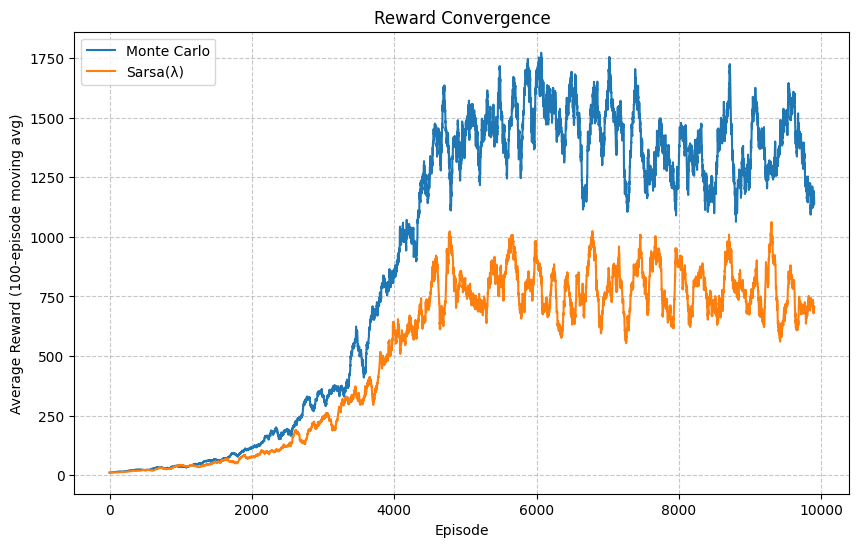

In [298]:
# Reward Convergence Plot
plt.figure(figsize=(10, 6))
plt.plot(np.convolve(mc_rewards, np.ones(100)/100, mode='valid'), label='Monte Carlo')
plt.plot(np.convolve(sarsa_rewards, np.ones(100)/100, mode='valid'), label='Sarsa(λ)')
plt.xlabel('Episode')
plt.ylabel('Average Reward (100-episode moving avg)')
plt.legend()
plt.title('Reward Convergence')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('figures/reward_convergence.png')
plt.show()

## 7. Generalization

In [299]:
def run_inference(env, agent, episodes=10, max_steps=1000, render=False):
    """
    Run inference with a trained SarsaLambdaAgent in the Text Flappy Bird environment.
    
    Args:
        env: The Gym environment (e.g., TextFlappyBird-v0)
        agent: Trained SarsaLambdaAgent instance
        episodes: Number of episodes to run (default: 10)
        max_steps: Maximum steps per episode (default: 1000)
        render: Whether to render the environment (default: False)
    
    Returns:
        total_rewards: List of total rewards per episode
        pipes_passed_list: List of pipes passed per episode
    """
    total_rewards = []
    pipes_passed_list = []

    # Set epsilon to 0 for fully greedy policy
    original_epsilon = agent.epsilon
    agent.epsilon = 0.0  # Disable exploration during inference

    for ep in range(episodes):
        # Reset environment
        reset_result = env.reset(seed=42 + ep)  # Unique seed per episode for reproducibility
        if isinstance(reset_result, tuple):
            state, info = reset_result
        else:
            state = reset_result

        # Convert state to tuple if needed
        state = tuple(state) if isinstance(state, np.ndarray) else state

        total_reward = 0
        done = False
        pipes_passed = 0
        last_pipe_x = state[0] if isinstance(state, tuple) and len(state) > 0 else 0
        step_count = 0

        while not done and step_count < max_steps:
            # Choose action greedily based on Q-values
            action = agent.choose_action(state)

            # Step in the environment
            step_result = env.step(action)
            if len(step_result) == 5:  # New Gym format: (obs, reward, terminated, truncated, info)
                next_state, reward, done, truncated, info = step_result
                done = done or truncated
            elif len(step_result) == 4:  # Old format: (obs, reward, done, info)
                next_state, reward, done, info = step_result
            else:
                next_state, reward, done = step_result[0], step_result[1], step_result[2]

            # Convert next_state to tuple if needed
            next_state = tuple(next_state) if isinstance(next_state, np.ndarray) else next_state

            # Count pipes passed
            if isinstance(next_state, tuple) and len(next_state) > 0:
                if next_state[0] > last_pipe_x:
                    pipes_passed += 1
                last_pipe_x = next_state[0]

            # Update state and accumulate reward
            state = next_state
            total_reward += reward
            step_count += 1

            # Optional rendering
            if render:
                env.render()

            if step_count >= max_steps:
                print(f"Episode {ep} reached max steps ({max_steps})")
                break

        total_rewards.append(total_reward)
        pipes_passed_list.append(pipes_passed)
        print(f"Episode {ep}: Total Reward = {total_reward:.2f}, Pipes Passed = {pipes_passed}")

    # Restore original epsilon (if you plan to resume training)
    agent.epsilon = original_epsilon

    print(f"\nInference Summary ({episodes} episodes):")
    print(f"Avg Reward: {np.mean(total_rewards):.2f} ± {np.std(total_rewards):.2f}")
    print(f"Avg Pipes Passed: {np.mean(pipes_passed_list):.2f} ± {np.std(pipes_passed_list):.2f}")

    return total_rewards, pipes_passed_list



Inference for Monte Carlo agent in a new env

In [312]:
gen_env = gym.make("TextFlappyBird-v0", height=15, width=21, pipe_gap=10)

# Run inference
inference_rewards, inference_pipes = run_inference(gen_env, mc_agent, episodes=10, max_steps=1000, render=True)


Episode 0 reached max steps (1000)
Episode 0: Total Reward = 1000.00, Pipes Passed = 90
Episode 1 reached max steps (1000)
Episode 1: Total Reward = 1000.00, Pipes Passed = 90
Episode 2 reached max steps (1000)
Episode 2: Total Reward = 1000.00, Pipes Passed = 90
Episode 3 reached max steps (1000)
Episode 3: Total Reward = 1000.00, Pipes Passed = 90
Episode 4 reached max steps (1000)
Episode 4: Total Reward = 1000.00, Pipes Passed = 90
Episode 5 reached max steps (1000)
Episode 5: Total Reward = 1000.00, Pipes Passed = 90
Episode 6 reached max steps (1000)
Episode 6: Total Reward = 1000.00, Pipes Passed = 90
Episode 7 reached max steps (1000)
Episode 7: Total Reward = 1000.00, Pipes Passed = 90
Episode 8 reached max steps (1000)
Episode 8: Total Reward = 1000.00, Pipes Passed = 90
Episode 9 reached max steps (1000)
Episode 9: Total Reward = 1000.00, Pipes Passed = 90

Inference Summary (10 episodes):
Avg Reward: 1000.00 ± 0.00
Avg Pipes Passed: 90.00 ± 0.00


Inference for Sarsa agent in a new environment

In [313]:
inference_rewards, inference_pipes = run_inference(gen_env, sarsa_agent, episodes=10, max_steps=1000, render=True)

Episode 0 reached max steps (1000)
Episode 0: Total Reward = 1000.00, Pipes Passed = 90
Episode 1 reached max steps (1000)
Episode 1: Total Reward = 1000.00, Pipes Passed = 90
Episode 2 reached max steps (1000)
Episode 2: Total Reward = 1000.00, Pipes Passed = 90
Episode 3 reached max steps (1000)
Episode 3: Total Reward = 1000.00, Pipes Passed = 90
Episode 4 reached max steps (1000)
Episode 4: Total Reward = 1000.00, Pipes Passed = 90
Episode 5 reached max steps (1000)
Episode 5: Total Reward = 1000.00, Pipes Passed = 90
Episode 6 reached max steps (1000)
Episode 6: Total Reward = 1000.00, Pipes Passed = 90
Episode 7 reached max steps (1000)
Episode 7: Total Reward = 1000.00, Pipes Passed = 90
Episode 8 reached max steps (1000)
Episode 8: Total Reward = 1000.00, Pipes Passed = 90
Episode 9 reached max steps (1000)
Episode 9: Total Reward = 1000.00, Pipes Passed = 90

Inference Summary (10 episodes):
Avg Reward: 1000.00 ± 0.00
Avg Pipes Passed: 90.00 ± 0.00


## 8. Conclusion
This notebook demonstrates the implementation of Monte Carlo and Sarsa(λ) agents for Text Flappy Bird. Sarsa(λ) outperforms Monte Carlo in convergence speed and reward, but is sensitive to parameters like λ. See `report.pdf` for detailed analysis.